In [1]:
# Make sure figures appears inline and animations works
%matplotlib widget

In [2]:
__version__ = '0.1.0'

# import engine module
import sirf.Gadgetron as pMR

# import CIL functionality for visualisation and iterative reconstruction
from cil.utilities.jupyter import islicer
from cil.optimisation.algorithms import FISTA, PDHG
from cil.plugins.ccpi_regularisation.functions.regularisers import  RegulariserFunction
from cil.plugins.ccpi_regularisation.functions import  FGP_TV
from cil.optimisation.functions import LeastSquares, ZeroFunction, L2NormSquared

from cil.framework import  AcquisitionGeometry, BlockDataContainer, BlockGeometry, ImageGeometry, ImageData
from cil.optimisation.operators import GradientOperator, BlockOperator, ZeroOperator, CompositionOperator,LinearOperator

# import further modules
import os
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation

### CIL BUG

In [3]:
# create image geometry
ig2D = ImageGeometry( voxel_num_y=3, voxel_num_x=4)

# create image data
x0_2D = ig2D.allocate('random')
x1_2D = ig2D.allocate('random')
x2_2D = ig2D.allocate('random')

# create bdc
bdc = BlockDataContainer(x0_2D,x1_2D,x2_2D)

print(bdc)
print(bdc.shape)
for i in bdc:
    print('shape 1 ', i.as_array().shape)
print(bdc)
print(bdc.shape)
for i in bdc:
    print('shape 2 ', i.as_array().shape)
    
print(bdc)
print(bdc.shape)
for i in range(3):
    print('range shape 1 ', bdc[i].as_array().shape)
print(bdc)
print(bdc.shape)
for i in range(3):
    print('range shape 2 ', bdc[i].as_array().shape)

(3, 1)
shape 1  (3, 4)
shape 1  (3, 4)
shape 1  (3, 4)
(3, 1)
(3, 1)
range shape 1  (3, 4)
range shape 1  (3, 4)
range shape 1  (3, 4)
(3, 1)
range shape 2  (3, 4)
range shape 2  (3, 4)
range shape 2  (3, 4)


In [4]:
# Trajectory for Golden angle radial acquisitions
def calc_rad_traj(ad):  
    dims = ad.dimensions()
    kx = np.linspace(-dims[2]//2, dims[2]//2, dims[2])
    ky = np.linspace(0, dims[0]-1, dims[0])
    
    # Check if angle is already specified:
    angRad = ky * (np.pi / 180) * (180 * 0.618034)

    # Normalise radial points between [-0.5 0.5]
    krad = kx
    krad = krad / (np.amax(np.abs(krad)) * 2)

    # Calculate trajectory
    rad_traj = np.zeros((dims[2], dims[0], 2), dtype=np.float32)
    rad_traj[:, :, 0] = krad.reshape(-1, 1) * np.cos(angRad)
    rad_traj[:, :, 1] = krad.reshape(-1, 1) * np.sin(angRad)
    rad_traj = np.moveaxis(rad_traj, 0, 1)    
    return(rad_traj)

In [5]:
pname = ''
fname = '2D_GRad_map_t1.h5'

In [6]:
# Load in the data
acq_data = pMR.AcquisitionData(pname + fname)
acq_data.sort_by_time()
acq_data = pMR.preprocess_acquisition_data(acq_data)

Started reading acquisitions from 2D_GRad_map_t1.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from 2D_GRad_map_t1.h5
Message received with ID: 5
Input stream has terminated


In [7]:
# Set trajectory
ktraj = calc_rad_traj(acq_data)
pMR.set_spiral2D_trajectory(acq_data, ktraj)

In [8]:
# Calculate coil sensitivity maps
csm = pMR.CoilSensitivityData()
csm.smoothness = 100
csm.calculate(acq_data)

## Dynamic reconstruction

In [9]:
# Parameters for dynamics
ndyn = 4
nrad_per_dyn = 16

In [10]:
# Go through each dynamic, create corresponding k-space and acquisition model
acq_dyn = [0] * ndyn
E_dyn = [0] * ndyn
im_dyn_inv = [0] * ndyn

for ind in range(ndyn):
    acq_idx_dyn = np.linspace(ind*nrad_per_dyn, (ind+1)*nrad_per_dyn-1, nrad_per_dyn)
    acq_dyn[ind] = acq_data.get_subset(acq_idx_dyn) 
    acq_dyn[ind].sort_by_time()
        
    # Create acquisition model
    E_tmp = pMR.AcquisitionModel(acqs=acq_dyn[ind], imgs=csm)
    E_tmp.set_coil_sensitivity_maps(csm)
    im_dyn_inv[ind] = E_tmp.inverse(acq_dyn[ind])

    E_dyn[ind] = pMR.AcquisitionModel(acqs=acq_dyn[ind], imgs=im_dyn_inv[ind])
    E_dyn[ind].set_coil_sensitivity_maps(csm)
    

In [11]:
# AcquisitionModel for each dynamic

# Create zero operator
ZOp = ZeroOperator(E_dyn[0].domain_geometry(), E_dyn[0].range_geometry())

E_dyn_diag = [ZOp,]*(ndyn*ndyn)
for ind in range(ndyn):
    E_dyn_diag[ind*ndyn+ind] = E_dyn[ind]
    
A = BlockOperator(*E_dyn_diag, shape=(ndyn, ndyn))

# Put together all the raw k-space data for each motion state in a BlockDataContainer
acq_dyn_block = BlockDataContainer(*acq_dyn)

# Starting image
x_init = A.adjoint(acq_dyn_block)

### FISTA without regularisation

In [12]:
# Set up optimisation
x_init_zero = x_init.copy()
x_init_zero.fill(0.0)

# Objective function
f = LeastSquares(A, acq_dyn_block, c=1)
f.calculate_Lipschitz()
G = ZeroFunction()

# Set up FISTA for least squares
fista = FISTA(initial=x_init_zero, f=f, g=G)
fista.max_iteration = 10
fista.update_objective_interval = 10

# Run FISTA
fista.run(100, verbose=True)

# Get result
im_fista_dyn_block = fista.get_output()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         10         0.000          5.34432e-03
       10         10         1.042          1.38184e-05
-------------------------------------------------------
       11         10         1.045                     
Stop criterion has been reached.



### FISTA with TV in space

In [13]:
import pysnooper
class BDCtoID():
    
    def __init__(self, bdc):
        
        self.bdc = bdc
        self.bdc_shape = bdc[0].shape
        
        # check that all datacontainers have the same shape
        all_shape = [i.shape for i in bdc.containers]
        num_containers = len(bdc.containers)
        if len(set(all_shape))>1:
            raise ValueError("Different shapes for containers")            
        if len(self.bdc_shape)==2:
            y, x = self.bdc_shape
            self.ig = ImageGeometry(voxel_num_y = y, voxel_num_x = x, channels=num_containers)
        elif len(self.bdc_shape)==3:            
            z,y,x = self.bdc_shape
            self.ig = ImageGeometry(voxel_num_z = z, voxel_num_y = y, voxel_num_x = x, 
                                    channels=num_containers)
        else:
            raise ValueError("not implemented")
        
    def IDarray(self, block_data_cont):
        tmp = []
        for i in range(block_data_cont.shape[0]):
            tmp.append(block_data_cont[i].as_array())
        tmp = np.stack(tmp, axis=0)
        self.id_cil = self.ig.allocate(dtype=block_data_cont[0].dtype)
        self.id_cil.fill(np.squeeze(tmp))
        return self.id_cil
    
    def BDC(self, image_data):
        if image_data.ndim<=2:
            raise ValueError("We cannot create a BlockDataContainer from a 2D array")
            
        num_slices = image_data.shape[0]
        splitted_arrays = np.squeeze(np.split(image_data.array, num_slices, axis=0))
        
        # reshape to make sure single dimensions are restored
        splitted_arrays = [np.reshape(arr, self.bdc_shape) for arr in splitted_arrays]
        
        # create new data container
        bdc = self.bdc.copy()
        for idx, container in enumerate(bdc.containers):
            container.fill(splitted_arrays[idx])
        return(bdc)

In [76]:
class FGP_TV_BDC():
    def __init__(self, bdc, alpha):
        self.bdctoid = BDCtoID(bdc) 
        self.fgp_tv = alpha*FGP_TV(nonnegativity=False)
        
    def __call__(self, bdc):
        x = self.bdctoid.IDarray(bdc)
        x_real = x.copy()
        x_real.fill(x.as_array().real)
        x_imag = x.copy()
        x_imag.fill(x.as_array().imag)
        return(np.sqrt(self.fgp_tv(x_real)**2 + self.fgp_tv(x_imag)**2))
    
    def proximal_numpy(self, xarr, tau):
        return(self.fgp_tv.proximal_numpy(xarr, tau))
        
    def proximal(self, bdc, tau, out=None):  
        x = self.bdctoid.IDarray(bdc)
        arr = x.as_array().copy() # .copy() added
        prox = x.copy()
        if np.iscomplexobj(arr):
            # do real and imag part indep
            in_arr = np.asarray(arr.real, dtype=np.float32, order='C')
            res, info = self.proximal_numpy(in_arr, tau)
            arr.real = res[:]
            in_arr = np.asarray(arr.imag, dtype=np.float32, order='C')
            res, info = self.proximal_numpy(in_arr, tau)
            arr.imag = res[:]
            self.info = info
            prox.fill(arr)
        else:
            arr = np.asarray(x.as_array(), dtype=np.float32, order='C')
            res, info = self.proximal_numpy(arr, tau)
            self.info = info
            prox.fill(res)
        
        if out is not None:
            out.fill(self.bdctoid.BDC(prox))
        else:
            out = self.bdctoid.BDC(prox)
            return out

In [79]:
# Set up optimisation
x_init_zero = x_init.copy()
#x_init_zero.fill(0.0)

# Objective function
f = LeastSquares(A, acq_dyn_block, c=1)
f.calculate_Lipschitz()

alpha = 2e-6
G = FGP_TV_BDC(x_init_zero, alpha)

# Set up FISTA for least squares
fista = FISTA(initial=x_init_zero, f=f, g=G)
fista.max_iteration = 100
fista.update_objective_interval = 10

# Run FISTA
fista.run(40, verbose=True)

# Get result
im_fista_dyn_block_tv = fista.get_output()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          5.34836e-03
       10        100         1.361          1.45485e-05
       20        100         1.337          9.43418e-06
       30        100         1.336          9.31194e-06
       40        100         1.336          9.28814e-06
-------------------------------------------------------
       40        100         1.336          9.28814e-06
Stop criterion has been reached.



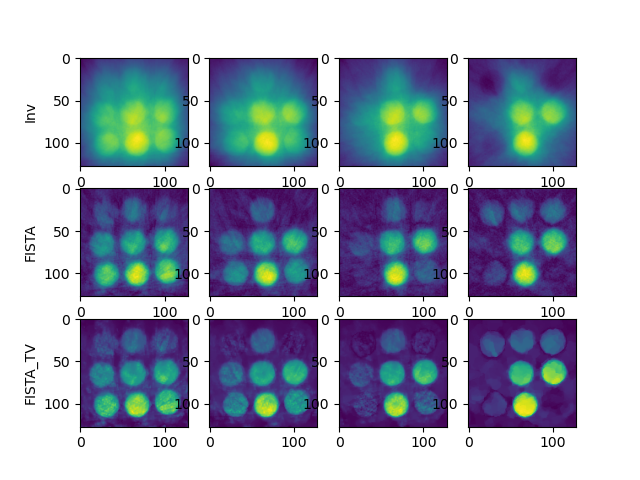

In [81]:
fig, ax = plt.subplots(3,ndyn)
for ind in range(ndyn):
    ax[0,ind].imshow(np.abs(np.squeeze(im_dyn_inv[ind].as_array())))
    ax[1,ind].imshow(np.abs(np.squeeze(im_fista_dyn_block[ind].as_array())))
    ax[2,ind].imshow(np.abs(np.squeeze(im_fista_dyn_block_tv[ind].as_array())))
    
    if ind == 0:
        ax[0,ind].set_ylabel('Inv')
        ax[1,ind].set_ylabel('FISTA')
        ax[2,ind].set_ylabel('FISTA_TV')